In [8]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from tensorflow.keras.layers import (Input, 
#                                      Conv3D, 
#                                      MaxPooling3D, 
#                                      Dropout, 
#                                      PReLU, 
#                                      BatchNormalization, 
#                                      Conv3DTranspose, UpSampling3D, 
#                                      Concatenate)

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [1]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [2]:
def conv_block(input_tensor, num_filters):
    x = Conv3D(num_filters, (3,3,3), padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Conv3D(num_filters, (3,3,3), padding='same')(x)
    x = Activation('relu')(x)
    return Add()([x, input_tensor]) # residual connection as per the VNET paper64

In [3]:
def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling3D((2,2,2))(x)
    return x, p

In [21]:
def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling3D((2,2,2))(input_tensor)
    x = Conv3D(num_filters, (1,1,1))(x) # 1X1X1 convolution operation to match the filters
    x = Add()([x, concat_tensor]) # skip connection implementation. VNET is a variant of UNET.
    x = conv_block(x, num_filters)
    return x

In [6]:
def vnet_regression(input_shape):
    inputs = Input(input_shape)
    
    e0, p0 = encoder_block(inputs, 16)
    e1, p1 = encoder_block(p0, 32)
    e2, p2 = encoder_block(p1, 64)
    e3, p3 = encoder_block(p2, 128)
    
    b0 = conv_block(p3, 256)
    
    d3 = decoder_block(b0, e3, 128)
    d2 = decoder_block(b3, e2, 64)
    d1 = decoder_block(b2, e1, 32)
    d0 = decoder_block(b1, e0, 16)
    
    outputs = Conv3D(1, (1,1,1), activation='linear')(d0)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [2]:
# # Motivation:
# # https://github.com/MiguelMonteiro/VNet-Tensorflow/blob/master/VNet.py

# # https://paperswithcode.com/method/prelu
    
# # PReLU layer
# # f(x) = alpha * x for x < 0
# # f(x) = x for x >= 0

# def conv3d_block(input_tensor, n_filters, kernel_size_ip = 3, batchnorm = True):
#     # first layer
#     x = Conv3D(filters = n_filters, 
#                kernel_size = (kernel_size_ip, 
#                               kernel_size_ip, 
#                               kernel_size_ip), 
#                kernel_initializer = 'he_normal', 
#                padding = 'same')(input_tensor)
#     if batchnorm:
#         x = BatchNormalization()(x)
        
#     x = PReLU()(x)
    
#     # second layer
#     x = Conv3D(filters = n_filters, 
#                kernel_size = (kernel_size_ip, 
#                               kernel_size_ip, 
#                               kernel_size_ip), 
#                kernel_initializer = 'he_normal',
#                padding = 'same')(x)
#     if batchnorm:
#         x = BatchNormalization()(x)
        
#     x = PReLU()(x)
#     return x

# def vnet(input_img, n_filters = 64, dropout = 0.5, batchnorm = True):
#     # Contracting Path
#     c1 = conv3d_block(input_img, n_filters * 1, kernel_size_ip = 3, batchnorm = batchnorm)
#     p1 = MaxPooling3D((2, 2, 2))(c1)
#     p1 = Dropout(dropout)(p1)
  
#     c2 = conv3d_block(p1, n_filters * 2, kernel_size_ip = 3, batchnorm = batchnorm)
#     p2 = MaxPooling3D((2, 2, 2))(c2)
#     p2 = Dropout(dropout)(p2)
  
#     c3 = conv3d_block(p2, n_filters * 4, kernel_size_ip = 3, batchnorm = batchnorm)

#     # Expansive Path
#     u4 = Conv3DTranspose(n_filters * 2, (3, 3, 3), strides = (2, 2, 2), padding = 'same')(c3)
#     u4 = concatenate([u4, c2])
#     u4 = Dropout(dropout)(u4)
#     c4 = conv3d_block(u4, n_filters * 2, kernel_size_ip = 3, batchnorm = batchnorm)

#     u5 = Conv3DTranspose(n_filters * 1, (3, 3, 3), strides = (2, 2, 2), padding = 'same')(c4)
#     u5 = concatenate([u5, c1])
#     u5 = Dropout(dropout)(u5)
#     c5 = conv3d_block(u5, n_filters * 1, kernel_size_ip = 3, batchnorm = batchnorm)
  
#     outputs = Conv3D(1, (1, 1, 1), activation='linear')(c5)
#     model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
#     return model

In [3]:
# from tensorflow.keras.layers import PReLU

# def create_original_vnet(input_shape):
#     # input layer
#     inputs = Input(input_shape)

#     # Layer 1
#     conv1 = Conv3D(16, (5, 5, 5), padding='same')(inputs)
#     conv1 = PReLU()(conv1)
#     concat1 = Concatenate()([inputs, conv1])

#     # Layer 2
#     conv2 = Conv3D(32, (3, 3, 3), padding='same', strides=2)(concat1)
#     conv2 = PReLU()(conv2)
#     conv2 = Conv3D(32, (3, 3, 3), padding='same')(conv2)
#     conv2 = PReLU()(conv2)
#     concat2 = Concatenate()([Conv3D(32, (1, 1, 1), strides=2)(concat1), conv2])

#     # Layer 3
#     conv3 = Conv3D(64, (3, 3, 3), padding='same', strides=2)(concat2)
#     conv3 = PReLU()(conv3)
#     conv3 = Conv3D(64, (3, 3, 3), padding='same')(conv3)
#     conv3 = PReLU()(conv3)
#     concat3 = Concatenate()([Conv3D(64, (1, 1, 1), strides=2)(concat2), conv3])

#     # Layer 4
#     conv4 = Conv3D(128, (3, 3, 3), padding='same', strides=2)(concat3)
#     conv4 = PReLU()(conv4)
#     conv4 = Conv3D(128, (3, 3, 3), padding='same')(conv4)
#     conv4 = PReLU()(conv4)
#     concat4 = Concatenate()([Conv3D(128, (1, 1, 1), strides=2)(concat3), conv4])

#     # Layer 5 (Bottom layer)
#     conv5 = Conv3D(256, (3, 3, 3), padding='same')(concat4)
#     conv5 = PReLU()(conv5)
#     conv5 = Conv3D(256, (3, 3, 3), padding='same')(conv5)
#     conv5 = PReLU()(conv5)

#     # Layer upsample 4
#     up4 = UpSampling3D(size=(2, 2, 2))(conv5)
#     concat_up4 = Concatenate()([up4, conv4])

#     # Layer 6
#     conv6 = Conv3D(128, (3, 3, 3), padding='same')(concat_up4)
#     conv6 = PReLU()(conv6)
#     conv6 = Conv3D(128, (3, 3, 3), padding='same')(conv6)
#     conv6 = PReLU()(conv6)

#     # Layer upsample 3
#     up3 = UpSampling3D(size=(2, 2, 2))(conv6)
#     concat_up3 = Concatenate()([up3, conv3])

#     # Layer 7
#     conv7 = Conv3D(64, (3, 3, 3), padding='same')(concat_up3)
#     conv7 = PReLU()(conv7)
#     conv7 = Conv3D(64, (3, 3, 3), padding='same')(conv7)
#     conv7 = PReLU()(conv7)

#     # Layer upsample 2
#     up2 = UpSampling3D(size=(2, 2, 2))(conv7)
#     concat_up2 = Concatenate()([up2, conv2])

#     # Layer 8
#     conv8 = Conv3D(32, (3, 3, 3), padding='same')(concat_up2)
#     conv8 = PReLU()(conv8)
#     conv8 = Conv3D(32, (3, 3, 3), padding='same')(conv8)
#     conv8 = PReLU()(conv8)

#     # Layer upsample 1
#     up1 = UpSampling3D(size=(2, 2, 2))(conv8)
#     concat_up1 = Concatenate()([up1, conv1])

#     # Layer 9
#     conv9 = Conv3D(16, (3, 3, 3), padding='same')(concat_up1)
#     conv9 = PReLU()(conv9)
#     conv9 = Conv3D(16, (3, 3, 3), padding='same')(conv9)
#     conv9 = PReLU()(conv9)

#     # Final softmax layer
#     outputs = Conv3D(1, (1, 1, 1), activation='linear')(conv9)

#     return Model(inputs=[inputs], outputs=[outputs])

In [4]:
# import tensorflow as tf
# from tensorflow.keras import Input, Model, layers

# def conv3d_block(input_tensor, n_filters, kernel_size_ip=3, strides=1, batchnorm=True):
#     # replace MaxPooling3D with StridedConvolution for downsampling
#     x = layers.Conv3D(filters=n_filters, 
#                       kernel_size=(kernel_size_ip, kernel_size_ip, kernel_size_ip), 
#                       strides=strides,
#                       kernel_initializer='he_normal', 
#                       padding='same')(input_tensor)
#     if batchnorm:
#         x = layers.BatchNormalization()(x)
        
#     x = layers.PReLU()(x)
    
#     # second layer
#     x = layers.Conv3D(filters=n_filters, 
#                       kernel_size=(kernel_size_ip, kernel_size_ip, kernel_size_ip), 
#                       kernel_initializer='he_normal', 
#                       padding='same')(x)
#     if batchnorm:
#         x = layers.BatchNormalization()(x)
        
#     x = layers.PReLU()(x)
#     return x

# def vnet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
#     # Contracting Path
#     c1 = conv3d_block(input_img, n_filters * 1, kernel_size=3, strides=1, batchnorm=batchnorm)
#     p1 = layers.Conv3D(filters=n_filters*2, kernel_size=(3,3,3), strides=2, padding='same')(c1)  # stride 2 replaces maxpool
#     p1 = layers.Dropout(dropout)(p1)
  
#     c2 = conv3d_block(p1, n_filters * 2, kernel_size=3, strides=1, batchnorm=batchnorm)
#     p2 = layers.Conv3D(filters=n_filters*4, kernel_size=(3,3,3), strides=2, padding='same')(c2)  # stride 2 replaces maxpool
#     p2 = layers.Dropout(dropout)(p2)
  
#     c3 = conv3d_block(p2, n_filters * 4, kernel_size=3, strides=1, batchnorm=batchnorm)
    
#     # Expansive Path
#     u4 = layers.Conv3DTranspose(n_filters * 2, (3, 3, 3), strides=(2, 2, 2), padding='same')(c3)
#     u4 = layers.concatenate([u4, c2])
#     u4 = layers.Dropout(dropout)(u4)
#     c4 = conv3d_block(u4, n_filters * 2, kernel_size=3, batchnorm=batchnorm)

#     u5 = layers.Conv3DTranspose(n_filters * 1, (3, 3, 3), strides=(2, 2, 2), padding='same')(c4)
#     u5 = layers.concatenate([u5, c1])
#     u5 = layers.Dropout(dropout)(u5)
#     c5 = conv3d_block(u5, n_filters * 1, kernel_size=3, batchnorm=batchnorm)

#     outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(c5)
#     model = tf.keras.Model(inputs=[input_img], outputs=[outputs])
#     return model

In [9]:
# the simulations can be generated by data_generation_nb notebook.
simulated_data = np.load('./generated_data/simulated_data_010124_5K.npy')

In [10]:
os.environ['PYTHONHASHSEED']=str(159)

np.random.seed(159)
tf.random.set_seed(159)

In [11]:
# Split the data
initial_state = simulated_data[:, 0]
final_state = simulated_data[:, 1]

# Compute the mean and std of the initial and final states
initial_state_mean, initial_state_std = np.mean(initial_state), np.std(initial_state)
final_state_mean, final_state_std = np.mean(final_state), np.std(final_state)

# Normalize the initial and final states
initial_state = (initial_state - initial_state_mean) / initial_state_std
final_state = (final_state - final_state_mean) / final_state_std

# Select one simulation's initial and final states
initial_conditions = initial_state[0]
final_density = final_state[0]

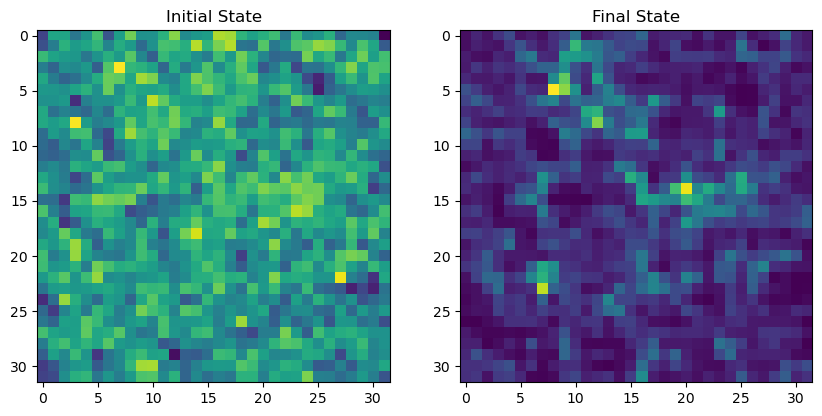

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# initial state and final state
axes[0].imshow(initial_conditions[0], cmap='viridis')
axes[0].set_title("Initial State")

axes[1].imshow(final_density[0], cmap='viridis')  
axes[1].set_title("Final State")

plt.show()

In [13]:
# train and test
X_train, X_test, y_train, y_test  = train_test_split(initial_state, final_state, test_size=0.15, random_state=123)

# further splitting it in training and testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=123)

In [14]:
# Recasting dimensions to 4D tensor (suitable for 3D convolutions) with the following dimensions: (batch_size, height, width, depth, num_channels)
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_val = np.reshape(X_val, (*X_val.shape, 1))
X_test = np.reshape(X_test, (*X_test.shape, 1))

y_train = np.reshape(y_train, (*y_train.shape, 1))
y_val = np.reshape(y_val, (*y_val.shape, 1))
y_test = np.reshape(y_test, (*y_test.shape, 1))

In [15]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape, y_test.shape

((3825, 32, 32, 32, 1),
 (425, 32, 32, 32, 1),
 (3825, 32, 32, 32, 1),
 (425, 32, 32, 32, 1),
 (750, 32, 32, 32, 1),
 (750, 32, 32, 32, 1))

In [16]:
# saving in case the instance failed
# np.save('X_test.npy', X_test)
# np.save('y_test.npy', y_test)

## Instantiate VNet model

In [17]:
# Parameters
Ngrid = 32  # grid size

In [18]:
# input_shape = (32, 32, 32, 1) 
# input_img = tf.keras.Input(shape=input_shape)

In [19]:
# vnet_model = vnet(input_img, n_filters=128, dropout=0.5, batchnorm=True)

In [22]:
vnet_model = vnet_regression((Ngrid, Ngrid, Ngrid, 1))

NameError: name 'b3' is not defined

In [ ]:
# Compile the model
vnet_model.compile(optimizer=Adam(), 
                   loss='mse',
                   metrics=['mae'],
                   run_eagerly=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
checkpoint = ModelCheckpoint('vnet.h5', monitor='loss', verbose=1, save_best_only=True)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

In [ ]:
history = vnet_model.fit(x=y_train, 
                         y=X_train, 
                         validation_data=(y_val, X_val), 
                         batch_size=32, 
                         epochs=50, 
                         callbacks=[early_stopping, reduce_lr, checkpoint])

In [ ]:
# Load the arrays from .npy files in case the instance needs to be started from here.
# y_test = np.load('y_test.npy')
# X_test = np.load('X_test.npy')

In [ ]:
# Load the model
# as the kernel was failing, the notebook was started from here again.
# vnet = load_model('old_vnet_model_5K.h5')
vnet = load_model('vnet_model.h5')

In [ ]:
vnet.summary()

In [ ]:
eval_results = vnet.evaluate(x=X_test, y=y_test)
print(f"Evaluation Results:{eval_results}")

In [ ]:
predictions = vnet.predict(X_test)
predictions.shape

In [ ]:
np.min(predictions), np.min(X_test), np.max(predictions), np.max(X_test)

In [ ]:
vmin = min(np.min(predictions), np.min(X_test))
vmax = max(np.max(predictions), np.max(X_test))

vmin, vmax

In [ ]:
for test_index in range(5):  # Plot first 5 test cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot predicted initial state
    im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[0].set_title('Predicted Initial State')
    fig.colorbar(im, ax=axs[0])

    # Plot true initial state
    im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[1].set_title('True Initial State')
    fig.colorbar(im, ax=axs[1])

    # Plot given final state 
    im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], vmin=vmin, vmax=vmax)
    axs[2].set_title('Given Final State')
    fig.colorbar(im, ax=axs[2])

    plt.show()

In [ ]:
# calculating the error metrics
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter plot of True vs Predicted values')
plt.show()

------
# Script Complete